In this notebook I train a benchmark model. This means the users are one-hot encoded the pre-trained user embeddings are not used to train this model. The movie features do not consider NLP embeddings from the plot and title. The main goal is create a working pipeline for training a PyG model. And it can be used later to compare results from optimized models.

In [1]:
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt

import torch
from torch.nn import Linear, MSELoss
import torch.nn.functional as F

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.transforms import RandomLinkSplit, ToUndirected, AddSelfLoops, NormalizeFeatures

In [2]:
torch.__version__

'1.13.0+cpu'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Load data

In [4]:
user_df = pd.read_csv('data/movieLens100k_users.csv')

print(user_df.shape)
user_df.head()

(671, 1)


,userId
0,0
1,1
2,2
3,3
4,4


In [5]:
movie_df = pd.read_csv('data/movieLens100k_movies.csv')
movie_df.drop(columns=['plot', 'title'], axis=1, inplace=True)

print(movie_df.shape)
movie_df.head()

(9125, 26)


,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Sci-Fi,Thriller,War,Western,imdbRating,imdbVotes,runtime,year,num_popular_actors,num_popular_directors
0,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,1.528928,5.144229,-0.876122,0.158905,2.943417,4.502288
1,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0.174897,1.394602,-0.058951,0.158905,1.228413,-0.218854
2,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,-0.115253,-0.318207,-0.165539,0.158905,-0.486591,-0.218854
3,3,0,0,0,0,1,0,0,1,0,...,0,0,0,0,-1.082418,-0.426889,0.651632,0.158905,-0.486591,-0.218854
4,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,-0.792268,-0.248423,0.012107,0.158905,1.228413,-0.218854


In [6]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                9125 non-null   int64  
 1   Action                 9125 non-null   int64  
 2   Adventure              9125 non-null   int64  
 3   Animation              9125 non-null   int64  
 4   Children               9125 non-null   int64  
 5   Comedy                 9125 non-null   int64  
 6   Crime                  9125 non-null   int64  
 7   Documentary            9125 non-null   int64  
 8   Drama                  9125 non-null   int64  
 9   Fantasy                9125 non-null   int64  
 10  Film-Noir              9125 non-null   int64  
 11  Horror                 9125 non-null   int64  
 12  IMAX                   9125 non-null   int64  
 13  Musical                9125 non-null   int64  
 14  Mystery                9125 non-null   int64  
 15  Roma

In [7]:
rating_df = pd.read_csv('data/movieLens100k_ratings.csv')

print(rating_df.shape)
rating_df.head()

(100004, 3)


,userId,movieId,rating
0,0,1815,2.0
1,0,1962,2.5
2,0,2380,1.0
3,0,2925,3.0
4,0,1515,4.0


In [8]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                9125 non-null   int64  
 1   Action                 9125 non-null   int64  
 2   Adventure              9125 non-null   int64  
 3   Animation              9125 non-null   int64  
 4   Children               9125 non-null   int64  
 5   Comedy                 9125 non-null   int64  
 6   Crime                  9125 non-null   int64  
 7   Documentary            9125 non-null   int64  
 8   Drama                  9125 non-null   int64  
 9   Fantasy                9125 non-null   int64  
 10  Film-Noir              9125 non-null   int64  
 11  Horror                 9125 non-null   int64  
 12  IMAX                   9125 non-null   int64  
 13  Musical                9125 non-null   int64  
 14  Mystery                9125 non-null   int64  
 15  Roma

In [9]:
assert not movie_df.isnull().values.any(), 'Null values in dataset!'

### Create Pytorch Geometric (heterogenious) Dataset

In [10]:
x_user = torch.eye(len(user_df['userId'].values))
x_user.size()

torch.Size([671, 671])

In [11]:
x_movie = movie_df.drop(columns=['movieId'], axis=1)
x_movie = torch.Tensor(x_movie.values)
x_movie.size()

torch.Size([9125, 25])

In [12]:
edge_index = torch.Tensor(rating_df[['userId', 'movieId']].values).swapaxes(1,0).to(torch.long)
edge_index.size(), edge_index

(torch.Size([2, 100004]),
 tensor([[   0,    0,    0,  ...,  670,  670,  670],
         [1815, 1962, 2380,  ..., 3213, 3220, 3223]]))

In [13]:
edge_label = torch.Tensor(rating_df['rating'].values)
edge_label.size(), edge_label

(torch.Size([100004]),
 tensor([2.0000, 2.5000, 1.0000,  ..., 4.0000, 3.5000, 3.5000]))

In [14]:
data = HeteroData()
data['user'].x = x_user
data['movie'].x = x_movie

data[('user', 'rates', 'movie')].edge_index = edge_index
data[('user', 'rates', 'movie')].edge_label = edge_label

data

HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 25] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  }
)

In [15]:
data = ToUndirected()(data)
del data[('movie', 'rev_rates', 'user')].edge_label
data

HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 25] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)

### Train / Test Split

In [16]:
# Perform a link-level split into training, validation, and test edges.
train_data, val_data, test_data = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

In [17]:
print('Train:', train_data)

Train: HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 25] },
  (user, rates, movie)={
    edge_index=[2, 80004],
    edge_label=[80004],
    edge_label_index=[2, 80004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 80004] }
)


In [18]:
train_data['user', 'movie'].edge_label_index.size(), train_data['user', 'movie'].edge_label_index

(torch.Size([2, 80004]),
 tensor([[ 212,  474,  600,  ...,  508,  147,   14],
         [5404, 5131, 5127,  ...,  691, 1042, 2612]]))

In [19]:
train_data['user', 'movie'].edge_label.size(), train_data['user', 'movie'].edge_label

(torch.Size([80004]),
 tensor([1.5000, 0.5000, 5.0000,  ..., 3.0000, 4.5000, 2.0000]))

In [20]:
data.x_dict

{'user': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 'movie': tensor([[ 0.0000,  1.0000,  1.0000,  ...,  0.1589,  2.9434,  4.5023],
         [ 0.0000,  1.0000,  0.0000,  ...,  0.1589,  1.2284, -0.2189],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.1589, -0.4866, -0.2189],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  1.1932, -0.4866,  4.5023],
         [ 0.0000,  0.0000,  0.0000,  ..., -2.8922, -0.4866, -0.2189],
         [ 0.0000,  0.0000,  0.0000,  ...,  1.1415, -0.4866, -0.2189]])}

### GNN Model

In [21]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin_out = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        z = self.lin_out(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=64).to(device)

In [22]:
# Due to lazy initialization, we need to run one model step so the number
# of parameters can be inferred:
with torch.no_grad():
    model.encoder(train_data.x_dict, train_data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters())

In [23]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = F.mse_loss(pred, target).sqrt()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [24]:
EPOCHS = 200
train_losses, val_losses, test_losses = [], [], []
for epoch in range(1, EPOCHS+1):
    train_loss = train()
    # train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    
    train_losses.append(train_loss), val_losses.append(val_rmse), test_losses.append(test_rmse)
    
    print(f'Epoch: {epoch:03d}\tTrain: {train_loss:.4f}\t'
          f'Val: {val_rmse:.4f}\tTest: {test_rmse:.4f}')
    # break

Epoch: 001	Train: 3.7295	Val: 3.6131	Test: 3.6454
Epoch: 002	Train: 3.6372	Val: 3.5180	Test: 3.5499
Epoch: 003	Train: 3.5414	Val: 3.4164	Test: 3.4476
Epoch: 004	Train: 3.4391	Val: 3.3074	Test: 3.3380
Epoch: 005	Train: 3.3295	Val: 3.1907	Test: 3.2206
Epoch: 006	Train: 3.2121	Val: 3.0624	Test: 3.0915
Epoch: 007	Train: 3.0829	Val: 2.9192	Test: 2.9473
Epoch: 008	Train: 2.9386	Val: 2.7593	Test: 2.7863
Epoch: 009	Train: 2.7774	Val: 2.5817	Test: 2.6073
Epoch: 010	Train: 2.5981	Val: 2.3855	Test: 2.4094
Epoch: 011	Train: 2.3999	Val: 2.1709	Test: 2.1924
Epoch: 012	Train: 2.1825	Val: 1.9404	Test: 1.9588
Epoch: 013	Train: 1.9484	Val: 1.7015	Test: 1.7157
Epoch: 014	Train: 1.7047	Val: 1.4715	Test: 1.4798
Epoch: 015	Train: 1.4694	Val: 1.2812	Test: 1.2815
Epoch: 016	Train: 1.2812	Val: 1.1738	Test: 1.1644
Epoch: 017	Train: 1.2043	Val: 1.1733	Test: 1.1539
Epoch: 018	Train: 1.2740	Val: 1.2286	Test: 1.2031
Epoch: 019	Train: 1.4120	Val: 1.2756	Test: 1.2477
Epoch: 020	Train: 1.5119	Val: 1.2899	Test: 1.2617


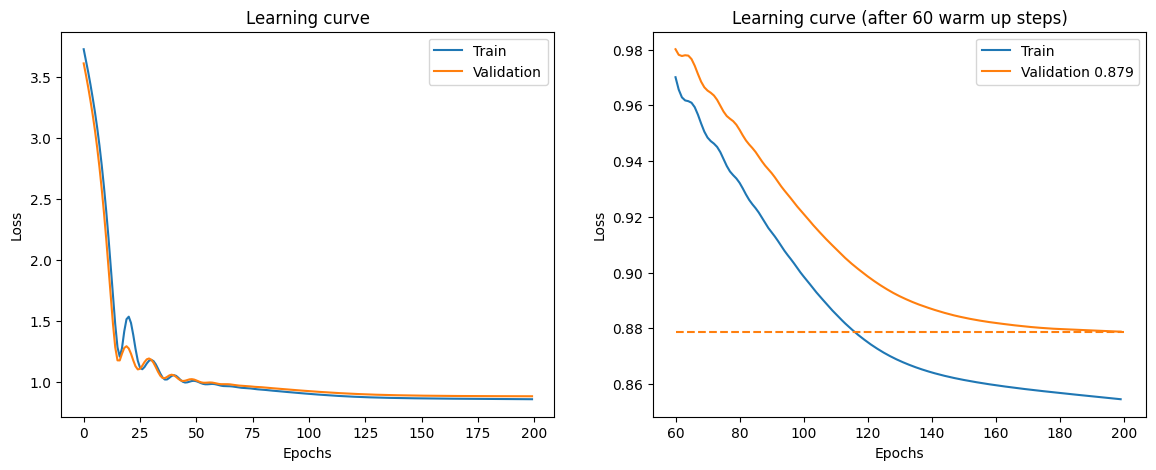

In [25]:
SKIP_WARM_UP_STEPS = 60

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax0.plot(train_losses, label='Train')
ax0.plot(val_losses, label='Validation')
ax0.set_title('Learning curve')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend()

ax1.plot(range(SKIP_WARM_UP_STEPS, len(train_losses)), train_losses[SKIP_WARM_UP_STEPS:], label='Train')
ax1.plot(range(SKIP_WARM_UP_STEPS, len(train_losses)), val_losses[SKIP_WARM_UP_STEPS:], label=f'Validation {round(val_losses[-1], 3)}')
ax1.hlines([val_losses[-1]], xmin=SKIP_WARM_UP_STEPS, xmax=EPOCHS, colors='C1', linestyles='--')
ax1.set_title(f'Learning curve (after {SKIP_WARM_UP_STEPS} warm up steps)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
plt.show()

### Inspect test results

In [26]:
model.eval()
pred = model(test_data.x_dict, test_data.edge_index_dict,
                test_data['user', 'movie'].edge_label_index)
pred = pred.clamp(min=0, max=5)
target = test_data['user', 'movie'].edge_label.float()
rmse = F.mse_loss(pred, target).sqrt()

In [27]:
pred[:20], target[:20]

(tensor([3.2415, 2.8440, 3.2105, 4.3942, 2.8451, 3.1798, 3.7587, 4.2948, 3.7038,
         3.7805, 3.7363, 3.8277, 3.5471, 3.6803, 2.7197, 3.8085, 3.8041, 3.5356,
         4.3891, 3.8320], grad_fn=<SliceBackward0>),
 tensor([4.0000, 1.5000, 3.0000, 5.0000, 4.0000, 5.0000, 4.0000, 5.0000, 5.0000,
         4.5000, 4.0000, 4.5000, 4.0000, 4.0000, 1.5000, 4.0000, 3.0000, 3.0000,
         4.0000, 3.5000]))

#### Evaluation

Mean squared Error (MSE) can be used as loss function. However, it is not a well suited metric to evaluate the model's recommendations. `Recall@k` fits better for evaluating the recommendations done by the model.  

In [28]:
def create_rec_dict_per_user() -> dict:
    """ Return a dictionnairy, with link predictions for each user.
    
        The dict keys are userId's and values a list of tuples. The
        first tuple value is the predicted rating and the second one
        the ground truth (rating). """

    user_rec_dict = defaultdict(list)
    test_users_unique = test_data['user', 'movie'].edge_label_index[0].unique()

    with torch.no_grad():
        for user_id in tqdm(test_users_unique):
            user_id = user_id.item()

            idxs = (test_data['user', 'movie'].edge_label_index[0] == user_id).nonzero().squeeze()
            edge_idxs = test_data['user', 'movie'].edge_label_index[:,idxs]
            
            true_ratings = test_data['user', 'movie'].edge_label[idxs]
            if true_ratings.ndimension() == 0:
                true_ratings = test_data['user', 'movie'].edge_label[idxs].unsqueeze(dim=0)

            pred_ratings = model(test_data.x_dict, test_data.edge_index_dict, edge_idxs)

            ratings = [(pred.item(), gt.item()) for gt, pred in zip(true_ratings, pred_ratings)] 
            user_rec_dict[user_id] = ratings
        
        return user_rec_dict


def recall_precision_at_k(user_rec_dict:dict, k:int, threshold:float) -> dict:
    """" """
    with torch.no_grad():
        precisions = dict()
        recalls = dict()

        for uid, user_ratings in user_rec_dict.items():
            
            user_ratings.sort(key=lambda x: x[0], reverse=True) 
             
            n_rel = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings])
            n_rec_k = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings[:k]])

            n_rel_and_rec_k = sum([((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k]])
            
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
        return recalls, precisions

user_rec_dict = create_rec_dict_per_user()

100%|██████████| 656/656 [03:23<00:00,  3.23it/s]


In [29]:
k = 20
threshold = 4.0
recalls, precisions = recall_precision_at_k(user_rec_dict, k, threshold)
rcl_at_k = sum(recalls.values()) / len(recalls.values())
prc_at_k = sum(precisions.values()) / len(precisions.values())

print(f'Recall@{k} (Threshold={threshold}):', round(rcl_at_k, 4))
print(f'Precision@{k} (Threshold={threshold}):', round(prc_at_k, 4))

threshold = 3.5
recalls, precisions = recall_precision_at_k(user_rec_dict, k=k, threshold=threshold)
rcl_at_k = sum(recalls.values()) / len(recalls.values())
prc_at_k = sum(precisions.values()) / len(precisions.values())

print(f'\nRecall@{k} (Threshold={threshold}):', round(rcl_at_k, 4))
print(f'Precision@{k} (Threshold={threshold}):', round(prc_at_k, 4))


Recall@20 (Threshold=4.0): 0.363
Precision@20 (Threshold=4.0): 0.3902

Recall@20 (Threshold=3.5): 0.6732
Precision@20 (Threshold=3.5): 0.7311
